In [1]:
import numpy as np
import torch
import pyro
import pyro.optim
from pyro.infer import *
from torch.distributions import constraints
from pyro import distributions as dst
import matplotlib.pylab as plt

In [2]:
from tracepredictive import *

In [3]:
N = 800
data = np.random.randn(N)*1.5+10

In [4]:
def GaussianKnownVariance(data, scale = 0.5):
    # and known hyperparameters
    loc = pyro.sample('loc', dst.Normal(0.,1.))
    return pyro.sample('obs', dst.Normal(loc,scale))

In [5]:
def guide(data, scale = 0.5):
    locloc = pyro.param('locloc', torch.zeros(1))
    locscale = pyro.param('locscale', torch.ones(1), constraint=constraints.positive)
    return pyro.sample('loc', dst.Normal(locloc, locscale))

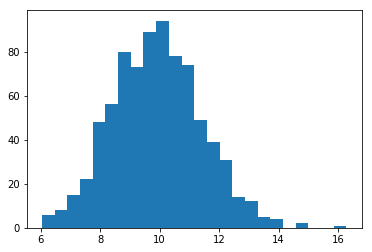

In [6]:
plt.hist(data,'auto');

In [7]:
def per_param_callable(module_name, param_name):
    return {"lr": 0.01, 'betas': [0.9, 0.99]}

In [8]:
conditioned_model = pyro.condition(GaussianKnownVariance, data = {'obs': torch.Tensor(data)})
optim = pyro.optim.Adam(per_param_callable)
elbo = Trace_ELBO()
svi = SVI(conditioned_model, guide, optim, loss=elbo)

In [9]:
losses = []
# optimize
for i in range(2000):
    loss = svi.step(data, scale=0.5)
    losses.append(loss)

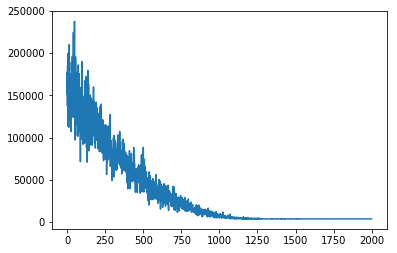

In [10]:
plt.plot(losses)

In [11]:
pyro.get_param_store().get_state()

{'params': {'locloc': tensor([9.9445], requires_grad=True),
  'locscale': tensor([-3.0056], requires_grad=True)},
 'constraints': {'locloc': Real(), 'locscale': GreaterThan(lower_bound=0.0)}}

In [12]:
pyro.param('locscale')

tensor([0.0495], grad_fn=<AddBackward0>)

In [13]:
pyro.clear_param_store()

In [14]:
conditioned_model2 = pyro.condition(GaussianKnownVariance, data = {'obs': torch.Tensor(data)})
optim2 = pyro.optim.Adam(per_param_callable)
elbo2 = Trace_ELBO()
svi2 = SVI(conditioned_model2, guide, optim2, loss=elbo)

In [15]:
losses = []
# optimize
for i in range(2000):
    loss = svi2.step(data, scale=1.5)
    losses.append(loss)

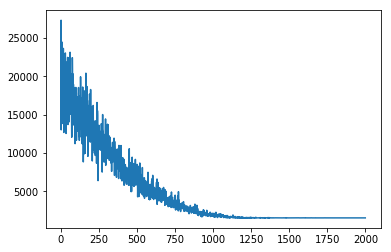

In [16]:
plt.plot(losses)

In [17]:
pyro.get_param_store().get_state()

{'params': {'locloc': tensor([9.9080], requires_grad=True),
  'locscale': tensor([-2.7735], requires_grad=True)},
 'constraints': {'locloc': Real(), 'locscale': GreaterThan(lower_bound=0.0)}}

In [18]:
pyro.param('locscale')

tensor([0.0624], grad_fn=<AddBackward0>)

In [19]:
trace_pred1 = TracePredictive(GaussianKnownVariance, svi, num_samples=1000).run(data, scale=0.5)

In [20]:
trace_pred2 = TracePredictive(GaussianKnownVariance, svi2, num_samples=1000).run(data, scale=1.5)

In [63]:
data = torch.Tensor(data)

In [100]:
# we sample 1000 models from each variational posterior
# find the log-probability of the data given each model
# take exp to convert to probabilities, sum over all models, take log to convert back to log-probabilities
# sum over all datapoints

In [117]:
logevidence1 = [torch.unsqueeze(trace.nodes['obs']['fn'].log_prob(data),dim=0) for trace in trace_pred1.exec_traces]
logevidence1 = torch.logsumexp(torch.cat(logevidence1),dim=0).sum()

In [118]:
logevidence1

tensor(1824.4991, grad_fn=<SumBackward0>)

In [119]:
logevidence2 = [torch.unsqueeze(trace.nodes['obs']['fn'].log_prob(data),dim=0) for trace in trace_pred2.exec_traces]
logevidence2 = torch.logsumexp(torch.cat(logevidence2),dim=0).sum()

In [120]:
logevidence2

tensor(4068.9778, grad_fn=<SumBackward0>)

In [121]:
bayesfactor = logevidence2/logevidence1

In [122]:
bayesfactor

tensor(2.2302, grad_fn=<DivBackward0>)

In [126]:
pp1 = trace_pred1.marginal().empirical['_RETURN']
pp2 = trace_pred2.marginal().empirical['_RETURN']

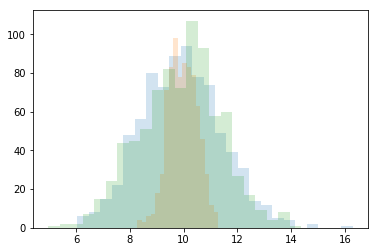

In [127]:
plt.hist(data,'auto', alpha=.2);
plt.hist(pp1((800,)).detach().numpy(),'auto', alpha=.2);
plt.hist(pp2((800,)).detach().numpy(),'auto', alpha=.2);